In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
m,n,p = 50,51,52
sphere = np.zeros((p, m,n))
for i in range(m) :
    for j in range(n) :
        for k in range(p) :
            v = np.array([i,j,k])
            d = v - np.array([20,10,10])
            d2 = v - np.array([30,39,20])
            if np.sum(d*d) < 10 or np.sum(d2*d2) < 10 :
                sphere[k, i,j] = 1

sphere[1,1:-2,1] = 1
sphere[-2,1:-2,1] = 1
sphere[1,1:-2,-2] = 1
sphere[-2,1:-2,-2] = 1

sphere[1:-2,1,1] = 1
sphere[1:-2,-2,1] = 1
sphere[1:-2,1,-2] = 1
sphere[1:-2,-2,-2] = 1

sphere[1,1,1:-2] = 1
sphere[-2,1,1:-2] = 1
sphere[1,-2,1:-2] = 1
sphere[-2,-2,1:-2] = 1


In [3]:
t = 0

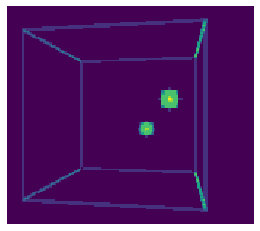

In [4]:
def render(camera_pos, center, array) :
    order = 1
    if abs(camera_pos[2]) > abs(camera_pos[0]) :
        camera_pos = camera_pos[::-1]
        center = center[::-1]
        array = np.swapaxes(array, 0, 2)
        order = -1
    p,m,n = array.shape
        
    c0 = center - camera_pos
    c0 = c0 / np.linalg.norm(c0)
    ci = np.array([0,1,0])
    ci = ci - np.sum(ci*c0)*c0
    ci = ci / np.linalg.norm(ci)
    cj = np.cross(c0,ci)

    display_m,display_n = 150,170
    fact = 0.05
    indices = np.indices((display_m,display_n)).swapaxes(0,2).swapaxes(0,1)
    pixel_pos = 0
    pixel_pos = camera_pos + c0*10
    pixel_pos = pixel_pos + fact*np.reshape(ci,[1,1,3])*(indices[:,:,0:1] - (display_m-1) / 2) 
    pixel_pos = pixel_pos + fact*np.reshape(cj,[1,1,3])*(indices[:,:,1:2] - (display_n-1) / 2)

    #solving : camera_pos[0] + (pixel_pos[:,:,0] - camera_pos[0])*x = k
    batch_fact = []
    for k in range(p) :
        fact = (k - camera_pos[0]) / (pixel_pos[:,:,0] - camera_pos[0])
        batch_fact.append(fact)
    batch_indices = []
    #Using : new indicies = camera_pos[1:] + (pixel_pos[1:] - camera_pos[1:])*x
    max_clip = np.stack([np.ones((display_m,display_n))*(m-1),np.ones((display_m,display_n))*(n-1)], axis=-1)
    for x in batch_fact:
        cam_pos_reshaped = np.reshape(camera_pos[1:],(1,1,2))
        intersect_indices = cam_pos_reshaped + (pixel_pos[:,:,1:] - cam_pos_reshaped)*np.reshape(x,(display_m,display_n,1))
        batch_indices.append(tf.clip_by_value(intersect_indices, 0, max_clip).numpy().astype(np.int))

    batch_indices = np.array(batch_indices)
    result = tf.gather_nd(array, batch_indices, batch_dims=1)
    return result.numpy().sum(axis = 0)[:,::order]
  
ims = []
array = sphere
center = (np.array([m,n,p])-1)/2
fig = plt.figure()

for i in range(15) :
    camera_pos = center +100*np.array([-np.cos(t),0,-np.sin(t)])
    plt.axis('off')
    res = render(camera_pos, center, array)
    ims.append([plt.imshow(res, animated=True)])
    t += 0.1
plt.imshow(render(camera_pos, center, array))

In [5]:
ani1 = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
HTML(ani1.to_html5_video())